In [1]:
import os
import re
import requests
import sys
from num2words import num2words
import os
import pandas as pd
import numpy as np
import tiktoken
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [2]:
df=pd.read_csv(os.path.join(os.getcwd(),'bill_sum_data.csv')) # This assumes that you have placed the bill_sum_data.csv in the same directory you are running Jupyter Notebooks
df

,Unnamed: 0,bill_id,text,summary,title,text_len,sum_len
0,0,110_hr37,SECTION 1. SHORT TITLE.\n\n This Act may be...,National Science Education Tax Incentive for B...,To amend the Internal Revenue Code of 1986 to ...,8494,321
1,1,112_hr2873,SECTION 1. SHORT TITLE.\n\n This Act may be...,Small Business Expansion and Hiring Act of 201...,To amend the Internal Revenue Code of 1986 to ...,6522,1424
2,2,109_s2408,SECTION 1. RELEASE OF DOCUMENTS CAPTURED IN IR...,Requires the Director of National Intelligence...,A bill to require the Director of National Int...,6154,463
3,3,108_s1899,SECTION 1. SHORT TITLE.\n\n This Act may be...,National Cancer Act of 2003 - Amends the Publi...,A bill to improve data collection and dissemin...,19853,1400
4,4,107_s1531,SECTION 1. SHORT TITLE.\n\n This Act may be...,Military Call-up Relief Act - Amends the Inter...,A bill to amend the Internal Revenue Code of 1...,6273,278
5,5,107_hr4541,SECTION 1. RELIQUIDATION OF CERTAIN ENTRIES PR...,Requires the Customs Service to reliquidate ce...,To provide for reliquidation of entries premat...,11691,114
6,6,111_s1495,SECTION 1. SHORT TITLE.\n\n This Act may be...,Service Dogs for Veterans Act of 2009 - Direct...,A bill to require the Secretary of Veterans Af...,5328,379
7,7,111_s3885,SECTION 1. SHORT TITLE.\n\n This Act may be...,Race to the Top Act of 2010 - Directs the Secr...,A bill to provide incentives for States and lo...,16668,1525
8,8,113_hr1796,SECTION 1. SHORT TITLE.\n\n This Act may be...,Troop Talent Act of 2013 - Directs the Secreta...,Troop Talent Act of 2013,15352,2151
9,9,103_hr1987,SECTION 1. SHORT TITLE.\n\n This Act may be...,Taxpayer's Right to View Act of 1993 - Amends ...,Taxpayer's Right to View Act of 1993,5633,894


In [3]:
df_bills = df[['text', 'summary', 'title']]
df_bills

,text,summary,title
0,SECTION 1. SHORT TITLE.\n\n This Act may be...,National Science Education Tax Incentive for B...,To amend the Internal Revenue Code of 1986 to ...
1,SECTION 1. SHORT TITLE.\n\n This Act may be...,Small Business Expansion and Hiring Act of 201...,To amend the Internal Revenue Code of 1986 to ...
2,SECTION 1. RELEASE OF DOCUMENTS CAPTURED IN IR...,Requires the Director of National Intelligence...,A bill to require the Director of National Int...
3,SECTION 1. SHORT TITLE.\n\n This Act may be...,National Cancer Act of 2003 - Amends the Publi...,A bill to improve data collection and dissemin...
4,SECTION 1. SHORT TITLE.\n\n This Act may be...,Military Call-up Relief Act - Amends the Inter...,A bill to amend the Internal Revenue Code of 1...
5,SECTION 1. RELIQUIDATION OF CERTAIN ENTRIES PR...,Requires the Customs Service to reliquidate ce...,To provide for reliquidation of entries premat...
6,SECTION 1. SHORT TITLE.\n\n This Act may be...,Service Dogs for Veterans Act of 2009 - Direct...,A bill to require the Secretary of Veterans Af...
7,SECTION 1. SHORT TITLE.\n\n This Act may be...,Race to the Top Act of 2010 - Directs the Secr...,A bill to provide incentives for States and lo...
8,SECTION 1. SHORT TITLE.\n\n This Act may be...,Troop Talent Act of 2013 - Directs the Secreta...,Troop Talent Act of 2013
9,SECTION 1. SHORT TITLE.\n\n This Act may be...,Taxpayer's Right to View Act of 1993 - Amends ...,Taxpayer's Right to View Act of 1993


In [4]:
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

# s is input text
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.strip()
    
    return s

df_bills['text']= df_bills["text"].apply(lambda x : normalize_text(x))

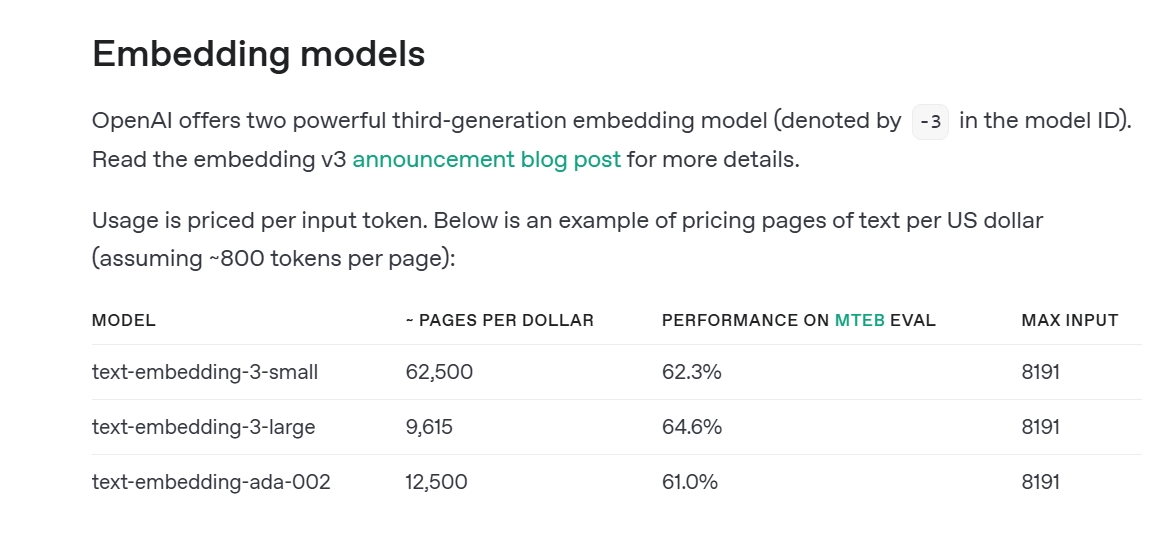

In [5]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df_bills['n_tokens'] = df_bills["text"].apply(lambda x: len(tokenizer.encode(x)))
df_bills = df_bills[df_bills.n_tokens<8192]
len(df_bills)

20

In [6]:
df_bills

,text,summary,title,n_tokens
0,SECTION 1. SHORT TITLE. This Act may be cited ...,National Science Education Tax Incentive for B...,To amend the Internal Revenue Code of 1986 to ...,1466
1,SECTION 1. SHORT TITLE. This Act may be cited ...,Small Business Expansion and Hiring Act of 201...,To amend the Internal Revenue Code of 1986 to ...,1183
2,SECTION 1. RELEASE OF DOCUMENTS CAPTURED IN IR...,Requires the Director of National Intelligence...,A bill to require the Director of National Int...,937
3,SECTION 1. SHORT TITLE. This Act may be cited ...,National Cancer Act of 2003 - Amends the Publi...,A bill to improve data collection and dissemin...,3670
4,SECTION 1. SHORT TITLE. This Act may be cited ...,Military Call-up Relief Act - Amends the Inter...,A bill to amend the Internal Revenue Code of 1...,1038
5,SECTION 1. RELIQUIDATION OF CERTAIN ENTRIES PR...,Requires the Customs Service to reliquidate ce...,To provide for reliquidation of entries premat...,2026
6,SECTION 1. SHORT TITLE. This Act may be cited ...,Service Dogs for Veterans Act of 2009 - Direct...,A bill to require the Secretary of Veterans Af...,880
7,SECTION 1. SHORT TITLE. This Act may be cited ...,Race to the Top Act of 2010 - Directs the Secr...,A bill to provide incentives for States and lo...,2815
8,SECTION 1. SHORT TITLE. This Act may be cited ...,Troop Talent Act of 2013 - Directs the Secreta...,Troop Talent Act of 2013,2479
9,SECTION 1. SHORT TITLE. This Act may be cited ...,Taxpayer's Right to View Act of 1993 - Amends ...,Taxpayer's Right to View Act of 1993,947


In [7]:
sample_encode = tokenizer.encode(df_bills.text[0]) 
decode = tokenizer.decode_tokens_bytes(sample_encode)
decode

[b'SECTION',
 b' ',
 b'1',
 b'.',
 b' SHORT',
 b' TITLE',
 b'.',
 b' This',
 b' Act',
 b' may',
 b' be',
 b' cited',
 b' as',
 b' the',
 b' ``',
 b'National',
 b' Science',
 b' Education',
 b' Tax',
 b' In',
 b'cent',
 b'ive',
 b' for',
 b' Businesses',
 b' Act',
 b' of',
 b' ',
 b'200',
 b'7',
 b"''.",
 b' SEC',
 b'.',
 b' ',
 b'2',
 b'.',
 b' C',
 b'RED',
 b'ITS',
 b' FOR',
 b' CERT',
 b'AIN',
 b' CONTRIBUT',
 b'IONS',
 b' BEN',
 b'EF',
 b'IT',
 b'ING',
 b' SC',
 b'IENCE',
 b',',
 b' TECHNO',
 b'LOGY',
 b',',
 b' ENGINE',
 b'ERING',
 b',',
 b' AND',
 b' MAT',
 b'HE',
 b'MAT',
 b'ICS',
 b' EDUC',
 b'ATION',
 b' AT',
 b' THE',
 b' ELEMENT',
 b'ARY',
 b' AND',
 b' SECOND',
 b'ARY',
 b' SCHOOL',
 b' LEVEL',
 b'.',
 b' (',
 b'a',
 b')',
 b' In',
 b' General',
 b'.--',
 b'Sub',
 b'part',
 b' D',
 b' of',
 b' part',
 b' IV',
 b' of',
 b' sub',
 b'chapter',
 b' A',
 b' of',
 b' chapter',
 b' ',
 b'1',
 b' of',
 b' the',
 b' Internal',
 b' Revenue',
 b' Code',
 b' of',
 b' ',
 b'198',
 b'6',


In [8]:
len(decode)

1466

In [ ]:
client = OpenAI(
    base_url = OPENAI_BASE_URL,
    api_key = OPENAI_API_KEY
)

In [ ]:
def generate_embeddings(text, model="text-embedding-3-large"):
    return client.embeddings.create(input=[text], model=model).data[0].embedding

df_bills['embedding_3_large'] = df_bills["text"].apply(
    lambda x: generate_embeddings(x, model='text-embedding-3-large'))

In [ ]:
df_bills

,text,summary,title,n_tokens,embedding_3_large
0,SECTION 1. SHORT TITLE. This Act may be cited ...,National Science Education Tax Incentive for B...,To amend the Internal Revenue Code of 1986 to ...,1466,"[-0.004925898741930723, 0.010357186198234558, ..."
1,SECTION 1. SHORT TITLE. This Act may be cited ...,Small Business Expansion and Hiring Act of 201...,To amend the Internal Revenue Code of 1986 to ...,1183,"[0.008487284183502197, 0.00894329696893692, 0...."
2,SECTION 1. RELEASE OF DOCUMENTS CAPTURED IN IR...,Requires the Director of National Intelligence...,A bill to require the Director of National Int...,937,"[0.020855097100138664, -0.00800553523004055, -..."
3,SECTION 1. SHORT TITLE. This Act may be cited ...,National Cancer Act of 2003 - Amends the Publi...,A bill to improve data collection and dissemin...,3670,"[0.01883178949356079, -0.01925409771502018, -0..."
4,SECTION 1. SHORT TITLE. This Act may be cited ...,Military Call-up Relief Act - Amends the Inter...,A bill to amend the Internal Revenue Code of 1...,1038,"[0.006724921520799398, -0.004916839767247438, ..."
5,SECTION 1. RELIQUIDATION OF CERTAIN ENTRIES PR...,Requires the Customs Service to reliquidate ce...,To provide for reliquidation of entries premat...,2026,"[0.02428256906569004, -0.01319838035851717, -0..."
6,SECTION 1. SHORT TITLE. This Act may be cited ...,Service Dogs for Veterans Act of 2009 - Direct...,A bill to require the Secretary of Veterans Af...,880,"[0.002131638815626502, -0.017564337700605392, ..."
7,SECTION 1. SHORT TITLE. This Act may be cited ...,Race to the Top Act of 2010 - Directs the Secr...,A bill to provide incentives for States and lo...,2815,"[0.03964132070541382, -0.017331430688500404, 0..."
8,SECTION 1. SHORT TITLE. This Act may be cited ...,Troop Talent Act of 2013 - Directs the Secreta...,Troop Talent Act of 2013,2479,"[0.012854204513132572, -0.029668856412172318, ..."
9,SECTION 1. SHORT TITLE. This Act may be cited ...,Taxpayer's Right to View Act of 1993 - Amends ...,Taxpayer's Right to View Act of 1993,947,"[0.025096649304032326, 0.017639270052313805, -..."


In [12]:
len(df_bills['embedding_3_large'][0])

3072

In [11]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [13]:
def get_embedding(text, model="text-embedding-3-large"): 
    return client.embeddings.create(input = [text], model=model).data[0].embedding

In [14]:
def search_docs(df, user_query, top_n=4, to_print=True):
    embedding = get_embedding(
        user_query,
        model="text-embedding-3-large" 
    )
    df["similarities"] = df.embedding_3_large.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    if to_print:
        display(res)
    return res

In [ ]:
res = search_docs(df_bills, "Can I get information on cable company tax revenue?", top_n=6)

,text,summary,title,n_tokens,embedding_3_large,similarities
9,SECTION 1. SHORT TITLE. This Act may be cited ...,Taxpayer's Right to View Act of 1993 - Amends ...,Taxpayer's Right to View Act of 1993,947,"[0.025096649304032326, 0.017639270052313805, -...",0.406509
0,SECTION 1. SHORT TITLE. This Act may be cited ...,National Science Education Tax Incentive for B...,To amend the Internal Revenue Code of 1986 to ...,1466,"[-0.004925898741930723, 0.010357186198234558, ...",0.280098
11,SECTION 1. SHORT TITLE. This Act may be cited ...,Wall Street Compensation Reform Act of 2010 - ...,A bill to amend the Internal Revenue Code of 1...,2331,"[0.022999417036771774, -0.009449372999370098, ...",0.247785
5,SECTION 1. RELIQUIDATION OF CERTAIN ENTRIES PR...,Requires the Customs Service to reliquidate ce...,To provide for reliquidation of entries premat...,2026,"[0.02428256906569004, -0.01319838035851717, -0...",0.215476
1,SECTION 1. SHORT TITLE. This Act may be cited ...,Small Business Expansion and Hiring Act of 201...,To amend the Internal Revenue Code of 1986 to ...,1183,"[0.008487284183502197, 0.00894329696893692, 0....",0.207521
4,SECTION 1. SHORT TITLE. This Act may be cited ...,Military Call-up Relief Act - Amends the Inter...,A bill to amend the Internal Revenue Code of 1...,1038,"[0.006724921520799398, -0.004916839767247438, ...",0.207292
